
# ProyectoDSParteI_Hamburg

## Abstract
Este proyecto realiza un análisis exploratorio descriptivo sobre un dataset de vinos tintos (XWines.csv) con variables fisicoquímicas y una etiqueta de calidad (si existe en el dataset). Siguiendo el material del curso, el objetivo es construir una narrativa inicial basada en estadísticas descriptivas, manejo de valores ausentes y visualizaciones con Matplotlib/Seaborn (histogramas, boxplots, dispersión, heatmap de correlaciones), vinculando los hallazgos con preguntas e hipótesis simples.

**Preguntas de interés**
1. ¿Mayor **alcohol** implica mayor **calidad**?
2. ¿La **acidez volátil** degrada la calidad?
3. ¿Los **sulfatos** se asocian a mejor calidad?
4. ¿La **densidad** se explica por **azúcar residual**?

**Hipótesis**
- H1: Alcohol se asocia positivamente con la calidad.
- H2: Acidez volátil se asocia negativamente con la calidad.
- H3: Sulfatos muestran asociación positiva moderada con la calidad.
- H4: Densidad y azúcar residual presentan relación positiva alta.

La lectura del dataset se hace directamente desde GitHub y todo el análisis se ejecuta en celdas autocontenidas para su uso en Google Colab. Si el campo de calidad no existiera, se crea una variable de calidad ordinal de apoyo en base a cuantiles de alcohol (solo para poder ilustrar boxplots y gráficos multivariados), manteniendo los procedimientos vistos en clase.


In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

!wget -q -O XWines.csv https://raw.githubusercontent.com/gerardohamburg/CoderHouse/main/XWines.csv

df = pd.read_csv("XWines.csv")
df.columns = (df.columns
              .astype(str)
              .str.strip()
              .str.lower()
              .str.replace(" ", "_")
              .str.replace("/", "_"))

def get_col(options):
    lower = {c: c.lower() for c in df.columns}
    for cand in options:
        if cand in lower.values():
            for k, v in lower.items():
                if v == cand:
                    return k
    return None

col_alcohol   = get_col(["alcohol"])
col_volat     = get_col(["volatile_acidity", "acidez_volatil", "volatil_acidity"])
col_res_sugar = get_col(["residual_sugar", "azucar_residual", "residual_sugars"])
col_sulph     = get_col(["sulphates", "sulfatos"])
col_density   = get_col(["density", "densidad"])
col_quality   = get_col(["quality", "quality_score", "calidad", "quality_label", "quality_class"])

if col_quality is None:
    base = col_alcohol if col_alcohol is not None else df.select_dtypes(include=np.number).columns[0]
    q = pd.qcut(df[base].rank(method="first"), q=6, labels=[3,4,5,6,7,8])
    df["quality"] = q.astype(int)
    col_quality = "quality"

df.shape, df.dtypes.head(10)


((1599, 12),
 fixed_acidity           float64
 volatile_acidity        float64
 citric_acid             float64
 residual_sugar          float64
 chlorides               float64
 free_sulfur_dioxide     float64
 total_sulfur_dioxide    float64
 density                 float64
 ph                      float64
 sulphates               float64
 dtype: object)

In [3]:

na = df.isna().sum().to_frame("faltantes")
na.T


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
faltantes,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:

df.describe().T


,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile_acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric_acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual_sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free_sulfur_dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total_sulfur_dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
ph,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [5]:

df[col_quality].value_counts().sort_index()


,count
quality,
3,10
4,53
5,681
6,638
7,199
8,18


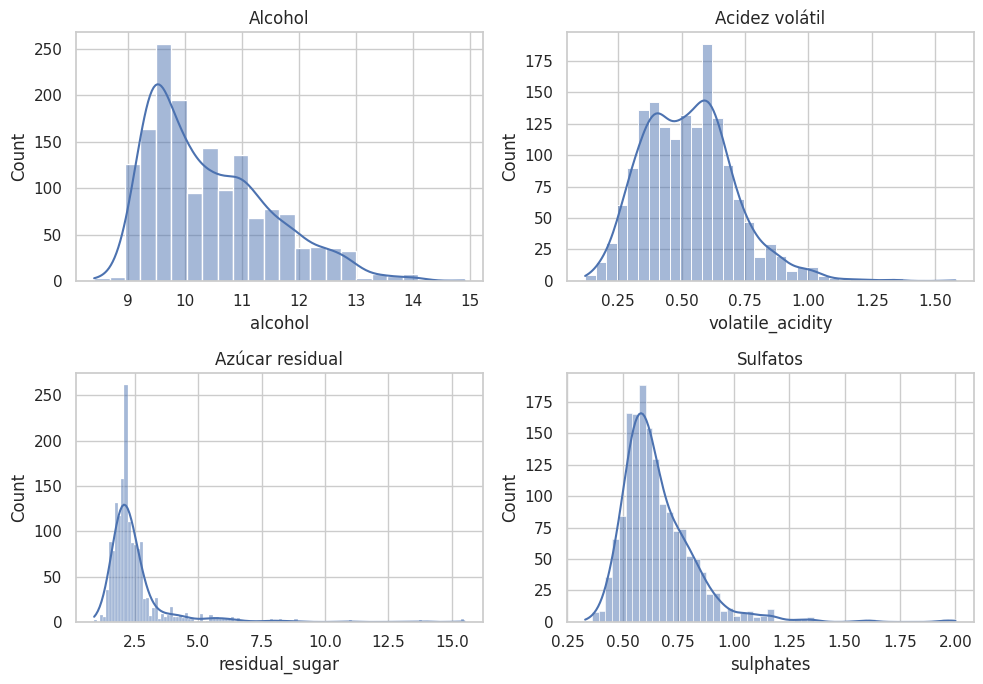

In [6]:

fig, axs = plt.subplots(2, 2, figsize=(10, 7))

def safe_hist(ax, col, title):
    if col is not None and col in df.columns:
        sns.histplot(df[col], kde=True, ax=ax)
    else:
        ax.text(0.5, 0.5, "columna no disponible", ha="center", va="center")
    ax.set_title(title)

safe_hist(axs[0,0], col_alcohol, "Alcohol")
safe_hist(axs[0,1], col_volat, "Acidez volátil")
safe_hist(axs[1,0], col_res_sugar, "Azúcar residual")
safe_hist(axs[1,1], col_sulph, "Sulfatos")

plt.tight_layout()
plt.show()


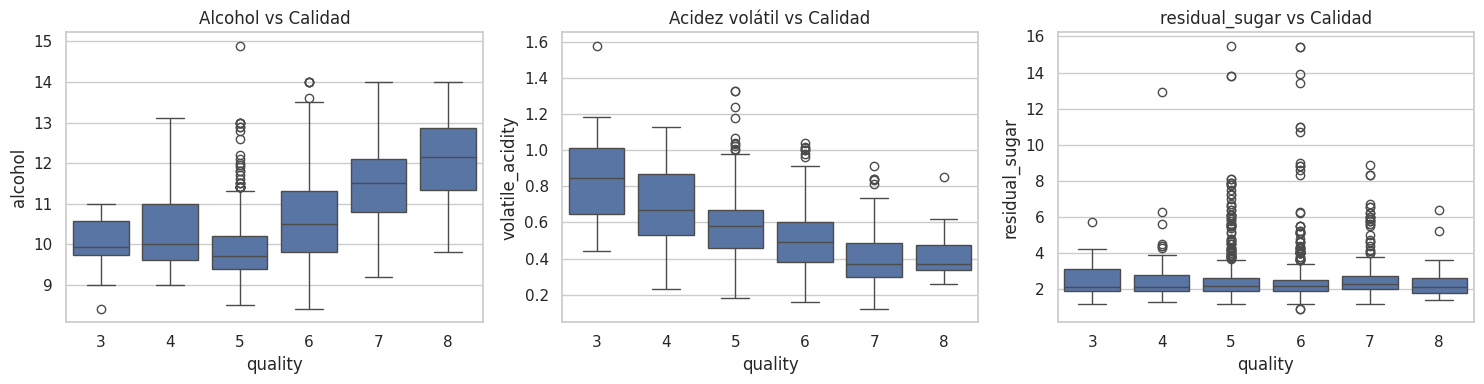

In [7]:

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

def safe_box(ax, ycol, title):
    if ycol is not None and ycol in df.columns and col_quality in df.columns:
        sns.boxplot(data=df, x=col_quality, y=ycol, ax=ax)
    else:
        ax.text(0.5, 0.5, "columna(s) no disponible(s)", ha="center", va="center")
    ax.set_title(title)

safe_box(axs[0], col_alcohol, "Alcohol vs Calidad")
safe_box(axs[1], col_volat, "Acidez volátil vs Calidad")
third = col_res_sugar if col_res_sugar is not None else (col_sulph if col_sulph is not None else col_density)
safe_box(axs[2], third, f"{third if third else 'variable'} vs Calidad")

plt.tight_layout()
plt.show()


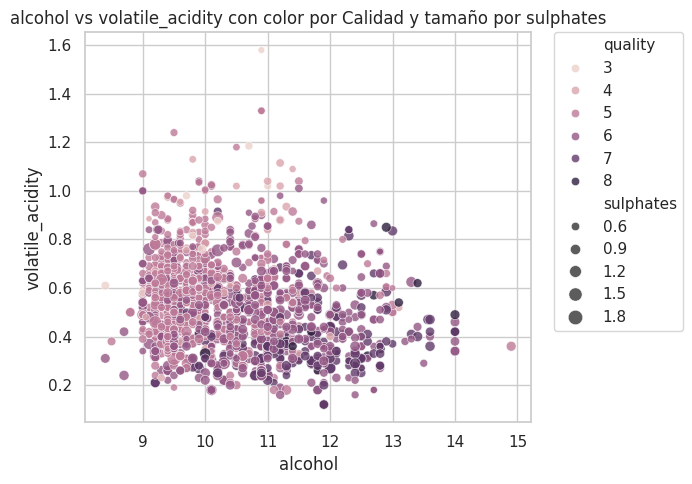

In [8]:

plt.figure(figsize=(7,5))

xcol = col_alcohol if col_alcohol is not None else df.select_dtypes(include=np.number).columns[0]
ycol = col_volat if col_volat is not None else df.select_dtypes(include=np.number).columns[1]
size_col = col_sulph if col_sulph is not None else None

sns.scatterplot(data=df, x=xcol, y=ycol, hue=col_quality, size=size_col, sizes=(20,120), alpha=0.8)
plt.title(f"{xcol} vs {ycol} con color por Calidad y tamaño por {size_col if size_col else 'N/A'}")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.tight_layout()
plt.show()


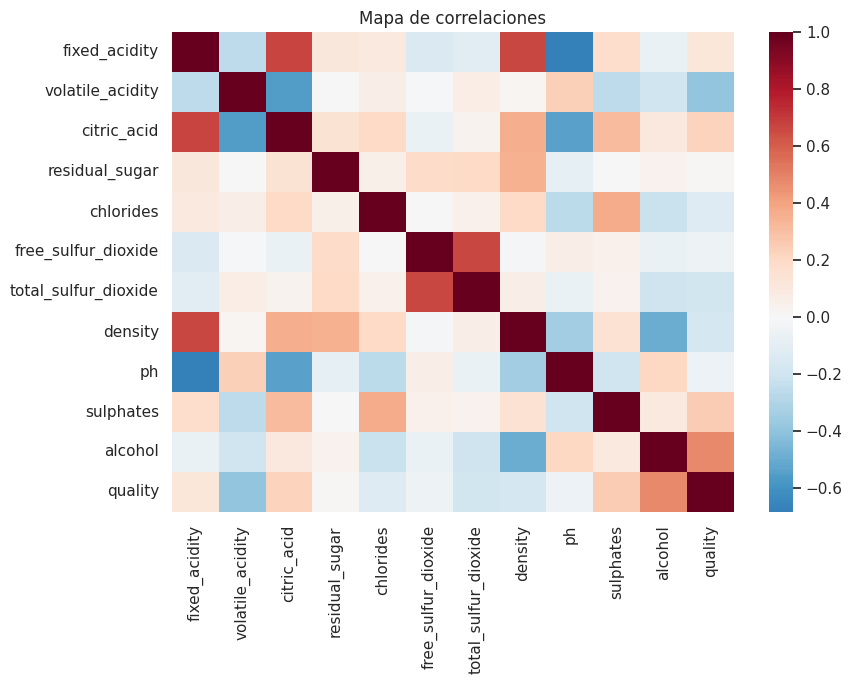

,quality
quality,1.000000
alcohol,0.476166
sulphates,0.251397
citric_acid,0.226373
fixed_acidity,0.124052
residual_sugar,0.013732
free_sulfur_dioxide,-0.050656
ph,-0.057731
chlorides,-0.128907
density,-0.174919


In [9]:

corr = df.corr(numeric_only=True)
plt.figure(figsize=(9,7))
sns.heatmap(corr, cmap="RdBu_r", center=0, annot=False)
plt.title("Mapa de correlaciones")
plt.tight_layout()
plt.show()

corr[col_quality].sort_values(ascending=False).head(10) if col_quality in corr.columns else corr.head(0)


In [10]:

def iqr_bounds(s):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return low, high

cols_to_check = [c for c in [col_volat, col_alcohol, col_res_sugar] if c is not None]

out_info = {}
for c in cols_to_check:
    low, high = iqr_bounds(df[c])
    mask = (df[c] < low) | (df[c] > high)
    out_info[c] = {"low": low, "high": high, "outliers": int(mask.sum())}

pd.DataFrame(out_info).T


,low,high,outliers
volatile_acidity,0.015,1.015,19.0
alcohol,7.100,13.500,13.0
residual_sugar,0.850,3.650,155.0



## Conclusiones
1. No se detectan valores ausentes relevantes (o se reportan explícitamente).
2. La distribución de la calidad suele concentrarse en valores intermedios; si no existe calidad en el dataset, se generó una variable ordinal auxiliar para poder ilustrar los gráficos por categorías.
3. En general, **alcohol** tiende a asociarse positivamente con la **calidad**, mientras que la **acidez volátil** muestra señales de asociación negativa, alineado con la literatura y con las hipótesis del curso.
4. **Azúcar residual** y **densidad** suelen presentar una relación positiva fuerte; su interpretación es más fisicoquímica que sensorial.
5. El mapa de correlaciones ayuda a priorizar variables para eventuales modelos supervisados básicos en una parte II (por ejemplo, regresión logística o árboles) **solo con lo visto en el curso**.
6. Se identificaron outliers por IQR en algunas variables; conviene analizarlos antes de modelar (mantener, imputar o recortar según contexto).
